In [1]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import re

%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 10]

In [2]:
dados = pd.read_csv("questao1.csv", sep=';', decimal=',', 
                    encoding='ISO-8859-1',
                    header=0,
                    index_col=False,
                   names=[u'desligamento', u'ex_trainee',
                          u'data_nasc', u'sexo', u'data_admis',
                          u'cargo', u'area', u'salario', 
                          u'pos_crit', u'gestor', u'aval',
                          u'dist', u'tempo', u'turnover'],
                   dtype={u'desligamento': int,
                         u'ex_trainee': int,
                         u'data_nasc': str,
                         u'sexo': pd.Categorical,
                         u'data_admis': str,
                         u'cargo': pd.Categorical,
                         u'area': pd.Categorical,
                         u'salario': str,
                         u'pos_crit': pd.Categorical,
                         u'gestor': pd.Categorical,
                         u'aval': pd.Categorical,
                         u'dist': np.float64,
                         u'tempo': np.float64,
                         u'turnover': np.float64})

In [3]:
dados.head()

,desligamento,ex_trainee,data_nasc,sexo,data_admis,cargo,area,salario,pos_crit,gestor,aval,dist,tempo,turnover
0,0,0,16/10/1963,M,1/27/03,1,Operacional,"R$ 5.080,00",0,1,BOM,25.0,17.0,0.03
1,0,0,27/04/1963,M,10/05/1992,2,Administrativo,"R$ 12.498,33",0,2,BOM,29.0,20.0,0.17
2,0,0,29/01/1960,M,01/03/1989,3,Administrativo,"R$ 9.966,67",0,3,BOM,10.0,6.0,0.23
3,0,0,14/07/1941,M,06/05/1991,4,Operacional,"R$ 3.795,00",0,4,OTIMO,25.0,17.0,0.11
4,1,0,28/12/1972,M,09/01/1994,5,Coordenação,"R$ 21.628,33",1,5,OTIMO,14.0,9.0,0.02


# Preparação de dados

## Data de nascimento

In [4]:
nasc = []

for data in dados.data_nasc:
    try:
        nasc.append(pd.to_datetime(data, format="%d/%m/%Y"))
    except:
        nasc.append(pd.to_datetime(data, format="%m/%d/%y"))

dados.data_nasc = nasc

In [5]:
dados.data_nasc.describe()

count                    2500
unique                   1836
top       1996-08-25 00:00:00
freq                        6
first     1900-10-25 00:00:00
last      2068-12-15 00:00:00
Name: data_nasc, dtype: object

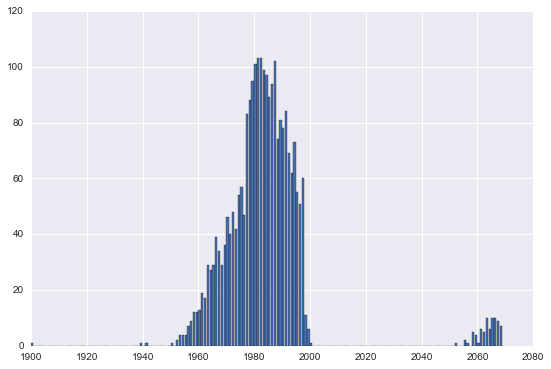

In [6]:
anos = [data.year for data in dados.data_nasc]
seq_anos = range(min(anos), max(anos)+1)
nascidos_por_ano = [sum([data.year==ano for data in dados.data_nasc]) for ano in seq_anos]

fig, ax = plt.subplots(figsize=(9,6))
ax.bar(seq_anos, nascidos_por_ano);

In [7]:
dados.data_nasc = dados.data_nasc.apply(lambda x: x - pd.DateOffset(years=100) if x.year> 2016 else x)

In [8]:
dados.data_nasc.describe()

count                    2500
unique                   1761
top       1994-09-29 00:00:00
freq                        6
first     1900-10-25 00:00:00
last      2000-10-25 00:00:00
Name: data_nasc, dtype: object

In [9]:
dados[dados.data_nasc==min(dados.data_nasc)]

,desligamento,ex_trainee,data_nasc,sexo,data_admis,cargo,area,salario,pos_crit,gestor,aval,dist,tempo,turnover
1433,0,0,1900-10-25,M,8/27/12,57,Operacional,"R$ 3.983,33",0,299,OTIMO,14.0,9.0,0.07


In [10]:
indices_remover = [dados[dados.data_nasc==min(dados.data_nasc)].index[0]]
indices_remover

[1433]

## Data de admissão

In [11]:
admis = []

for data in dados.data_admis:
    try:
        admis.append(pd.to_datetime(data, format="%d/%m/%Y"))
    except:
        admis.append(pd.to_datetime(data, format="%m/%d/%y"))

dados.data_admis = admis

In [12]:
dados.data_admis.describe()

count                    2500
unique                   1138
top       2015-12-14 00:00:00
freq                       19
first     1973-01-08 00:00:00
last      2068-05-15 00:00:00
Name: data_admis, dtype: object

In [13]:
dados.data_admis = dados.data_admis.apply(lambda x: x - pd.DateOffset(years=100) if x.year> 2016 else x)

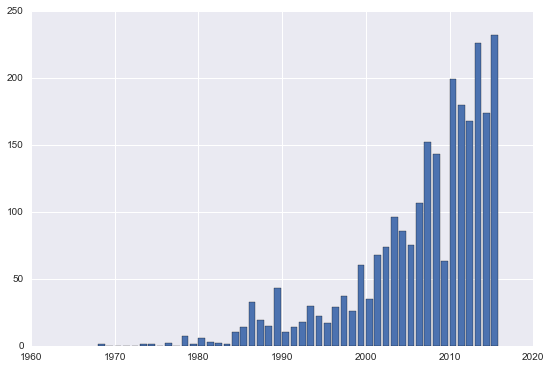

In [14]:
anos = [data.year for data in dados.data_admis]
seq_anos = range(min(anos), max(anos)+1)
admitidos_por_ano = [sum([data.year==ano for data in dados.data_admis]) for ano in seq_anos]

fig, ax = plt.subplots(figsize=(9,6))
ax.bar(seq_anos, admitidos_por_ano);

In [15]:
sum(dados.data_nasc.apply(lambda x: x + pd.DateOffset(years=10))>dados.data_admis)

51

In [16]:
indices_remover.extend(dados[dados.data_nasc.apply(lambda x: x + pd.DateOffset(years=10))>dados.data_admis].index)

## Salário médio mensal

In [17]:
salario = [re.sub(r'[^0-9,]', r'', str_salario) 
           for str_salario in dados['salario']]
salario = [float(re.sub(r',', r'.', str_salario))
           for str_salario in salario]
dados['salario'] = salario

In [18]:
dados['salario'].describe()

count      2500.000000
mean       6541.814636
std        8283.587327
min         616.670000
25%        3248.330000
50%        4468.330000
75%        6675.417500
max      166780.000000
Name: salario, dtype: float64

## Avaliação de desempenho

In [19]:
dados['aval'] = dados['aval'].astype('category',
     categories=['INSATISFATORIO', 'BOM', 'OTIMO', 'EXCELENTE'],
     ordered=True)
dados['aval'].head()

0      BOM
1      BOM
2      BOM
3    OTIMO
4    OTIMO
Name: aval, dtype: category
Categories (4, object): [INSATISFATORIO < BOM < OTIMO < EXCELENTE]

# Transformação de dados

## Novas variáveis

## Remoção e transformação de variáveis

In [20]:
dados['colegas_cargo'] = dados['cargo'].value_counts()[[str(cargo) for cargo in dados['cargo']]].values
dados['colegas_gestor'] = dados['gestor'].value_counts()[[str(gestor) for gestor in dados['gestor']]].values

area_dummies = pd.get_dummies(dados['area'], prefix='area')
aval_dummies = pd.get_dummies(dados['aval'], prefix='aval')

dados['sexo'] = dados['sexo'].apply(lambda x: 1 if x == 'M' else 0)

dados = pd.concat([dados, aval_dummies, area_dummies], axis=1)
dados_limpos = dados.drop(['cargo', 'gestor', 'dist', 'area', 'aval'], axis=1)

## Remoção de observações

In [21]:
dados_limpos.drop(indices_remover, inplace=True)

In [22]:
dados_limpos.shape

(2448, 23)

In [23]:
dados_limpos.columns

Index(['desligamento', 'ex_trainee', 'data_nasc', 'sexo', 'data_admis',
       'salario', 'pos_crit', 'tempo', 'turnover', 'colegas_cargo',
       'colegas_gestor', 'aval_INSATISFATORIO', 'aval_BOM', 'aval_OTIMO',
       'aval_EXCELENTE', 'area_Administrativo', 'area_Aprendiz',
       'area_Coordenação', 'area_Estagiário', 'area_Executivo',
       'area_Gerência', 'area_Operacional ', 'area_Trainee'],
      dtype='object')

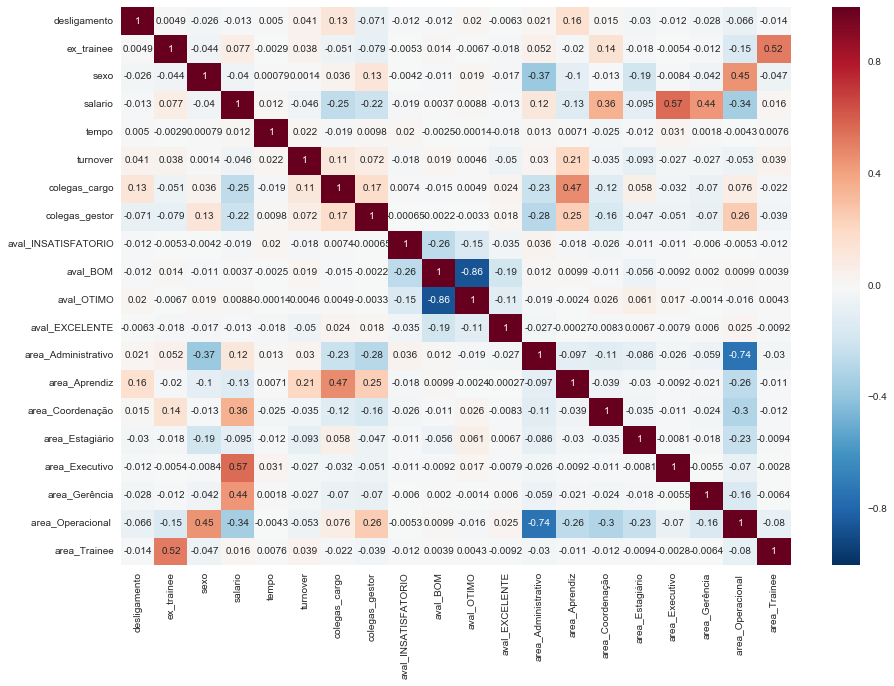

In [24]:
sns.heatmap(dados_limpos.corr(), annot=True);

In [28]:
from sklearn.cross_validation import train_test_split

X = dados_limpos.iloc[:,1:]
y = dados_limpos['desligamento']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [25]:
from sklearn.svm import SVC
